In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

In [2]:
import keras.backend as k

In [3]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 5

In [4]:
# load in pre-trained word vectors
print("Loading word vectors....")
word2vec ={}
with open("glove.6B.100d.txt",encoding="utf-8") as f:
    # is just a space sepereated text file in the format:
    # word vec[0] vec[1] vec[2] ....
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:],dtype='float32')
        word2vec[word] = vec
    print(f"Found {len(word2vec)} word vectors.")

Loading word vectors....
Found 400000 word vectors.


In [5]:
# prepare text samples and their labels
print("Loading in comments...")

Loading in comments...


In [6]:
train = pd.read_csv("toxic_comment_train.csv")
sentences = train["comment_text"].fillna("Dummy_Value").values
possible_labels = train.columns[2:]
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
targets = train[possible_labels].values

In [8]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [9]:
# get word -> ineteger mapping
word2idx = tokenizer.index_word
print(f"Found {len(word2idx)} unique tokens.")

Found 210337 unique tokens.


In [10]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences,maxlen =MAX_SEQUENCE_LENGTH)
print("Shape of data tensor:", data.shape)

Shape of data tensor: (159571, 100)


In [12]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx)+1)
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))
for i,word in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zers.
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [13]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=False)

In [14]:
print("Building model...")

Building model...


In [16]:
# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(15, return_sequences=True)(x)
# x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

model = Model(input_,output)
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.01), metrics=["accuracy"])

In [17]:
print("training model...")
r = model.fit(data,targets,batch_size=BATCH_SIZE,epochs=EPOCHS,
              validation_split=VALIDATION_SPLIT)

training model...
Epoch 1/5



998/998 [==============================] - 110s 104ms/step - loss: 0.1395 - accuracy: 0.8124 - val_loss: 0.0853 - val_accuracy: 0.9889
Epoch 2/5
998/998 [==============================] - 99s 99ms/step - loss: 0.0721 - accuracy: 0.9926 - val_loss: 0.0663 - val_accuracy: 0.9938
Epoch 3/5
998/998 [==============================] - 104s 104ms/step - loss: 0.0611 - accuracy: 0.9936 - val_loss: 0.0598 - val_accuracy: 0.9935
Epoch 4/5
998/998 [==============================] - 96s 97ms/step - loss: 0.0572 - accuracy: 0.9922 - val_loss: 0.0581 - val_accuracy: 0.9927
Epoch 5/5
998/998 [==============================] - 100s 100ms/step - loss: 0.0552 - accuracy: 0.9905 - val_loss: 0.0572 - val_accuracy: 0.9903


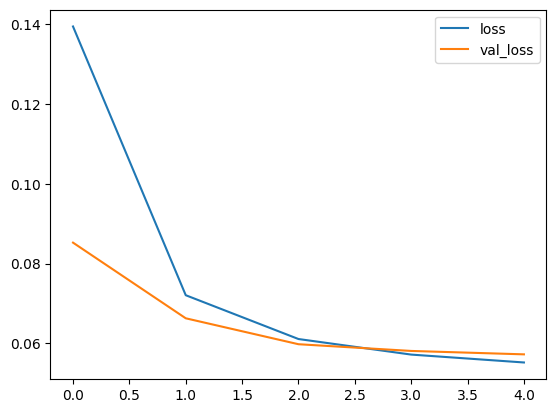

In [18]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

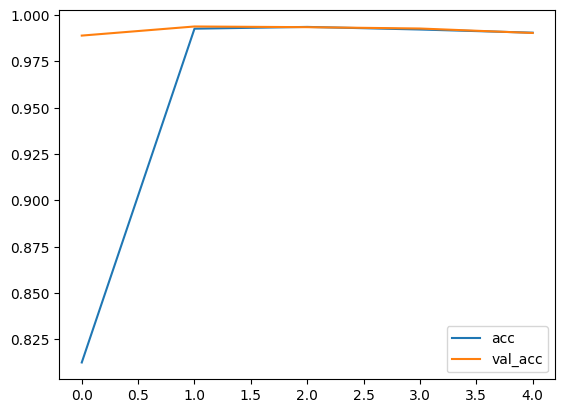

In [19]:
# accuracies
plt.plot(r.history['accuracy'],label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

In [20]:
p = model.predict(data)

4987/4987 [==============================] - 125s 25ms/step


In [21]:
aucs = []
for j in range(6):
    auc=roc_auc_score(targets[:,j],p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9728390602022755
